<a href="https://colab.research.google.com/github/jingairpi/sophia/blob/main/notebooks/gpt2_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jingairpi/sophia.git

%cd sophia
!pip install -e .

!pip install tiktoken

fatal: destination path 'sophia' already exists and is not an empty directory.
/content/sophia
Obtaining file:///content/sophia
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sophia (pyproject.toml) ... done
  Created wheel for sophia: filename=sophia-0.1.0-py3-none-any.whl size=2001 sha256=15cbf0ae7cce149c45a48a1304f5de7502d99fd404ab4db0e16a0fc3a6a00312
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ayukbgb/wheels/1a/af/0b/fc7ca0f0cb1c6b02d08716769a26dc8c73baaa78bf78172155
Successfully built sophia
  Attempting uninstall: sophia
    Found existing installation: sophia 0.1.0
    Uninstalling sophia-0.1.0:
      Successfully uninstalled sophia-0.1.0


In [2]:
import requests
import numpy as np
import tiktoken

# Download Tiny Shakespeare.
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

# Get GPT-2 encoding.
enc = tiktoken.get_encoding("gpt2")

# Encode the text into token IDs.
tokens = enc.encode(text)
tokens = np.array(tokens, dtype=np.int32)

# Save tokens to a binary file.
with open("tiny_shakespeare.bin", "wb") as f:
    tokens.tofile(f)

print(f"Saved {len(tokens)} tokens to tiny_shakespeare.bin")

Saved 338025 tokens to tiny_shakespeare.bin


2025-02-19 19:41:02,658 - sophia.data.data_loader - INFO - Loaded 338025 tokens from tiny_shakespeare.bin
INFO:sophia.data.data_loader:Loaded 338025 tokens from tiny_shakespeare.bin
2025-02-19 19:41:02,663 - sophia.data.data_loader - INFO - DataLoader configured for 41 full batches.
INFO:sophia.data.data_loader:DataLoader configured for 41 full batches.
2025-02-19 19:41:12,857 - sophia.trainer.trainer - INFO - Model parameters initialized.
INFO:sophia.trainer.trainer:Model parameters initialized.
2025-02-19 19:41:13,000 - sophia.trainer.trainer - INFO - Optimizer and training state set up with learning rate 0.000100.
INFO:sophia.trainer.trainer:Optimizer and training state set up with learning rate 0.000100.
2025-02-19 19:41:13,002 - sophia.trainer.trainer - INFO - Training step function created and JIT-compiled.
INFO:sophia.trainer.trainer:Training step function created and JIT-compiled.
INFO:__main__:Starting training for 25 epochs...
INFO:__main__:Epoch 1 starting...
INFO:__main__:E

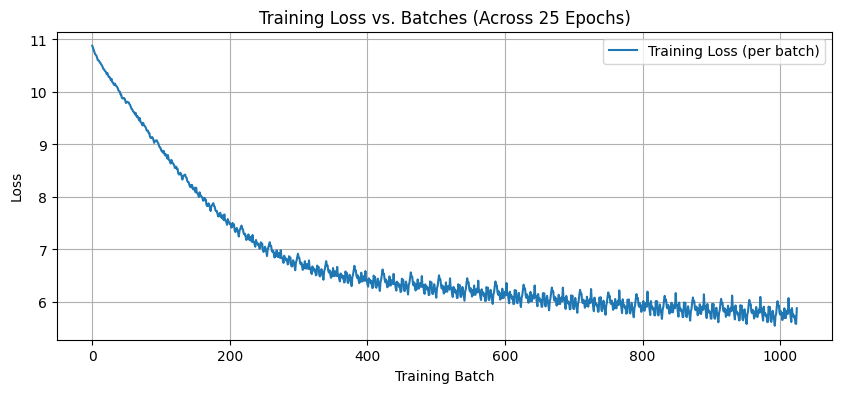

In [3]:
import time
import jax
import jax.numpy as jnp
import optax
from sophia.trainer.trainer import Trainer
from sophia.configs.gpt2 import GPT2Params, GPT2Config
from sophia.data.data_loader import DataLoader
from sophia.model.builder import build_model
import logging

# Configure logging (if not already configured).
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# -----------------------------------------------------------------------------
# Define a smaller GPT-2 model configuration (for resource constraints)
params = GPT2Params(
    n_layer=2,         # Two transformer blocks
    hidden_size=128,   # Smaller embedding dimension
    vocab_size=50257,  # Standard GPT-2 vocabulary size
    n_positions=256,   # Shorter sequence length for training/inference
    ffn_multiplier=4,
    dropout_rate=0.1,
)

config = GPT2Config.from_params(params)

# Instantiate the model using the builder.
model = build_model(config)

# Define optimizer configuration.
optimizer_config = {
    "learning_rate": 1e-4,
    "batch_size": 32,  # Adjust based on your available GPU memory
}

# Use a sequence length that matches your model's n_positions.
seq_len = 256

# Create a DataLoader instance for training with repeat disabled.
train_loader = DataLoader("tiny_shakespeare.bin", optimizer_config["batch_size"], seq_len, repeat=False)

# Create a random number generator key.
rng = jax.random.PRNGKey(0)

# Instantiate the Trainer.
trainer = Trainer(model, config.params, optimizer_config, train_loader, rng)

# -----------------------------------------------------------------------------
# Epoch-aware Training: Train for 25 epochs.
num_epochs = 25
all_training_losses = []

logger.info("Starting training for %d epochs...", num_epochs)
for epoch in range(num_epochs):
    logger.info("Epoch %d starting...", epoch + 1)
    epoch_losses = []

    data_iter = iter(train_loader)
    for batch in data_iter:
        trainer.rng, step_rng = jax.random.split(trainer.rng)
        start_time = time.time()
        trainer.state, loss, logits = trainer.train_step(trainer.state, batch, step_rng)
        elapsed = time.time() - start_time
        loss_val = float(loss)
        epoch_losses.append(loss_val)
        all_training_losses.append(loss_val)

    avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else float('nan')
    logger.info("Epoch %d complete. Average Training Loss: %.4f", epoch + 1, avg_loss)
    train_loader.reset()

logger.info("Training complete.")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(all_training_losses, label="Training Loss (per batch)")
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Batches (Across 25 Epochs)")
plt.legend()
plt.grid(True)
plt.show()